In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
test_data = h5py.File('C:/Users/meetd/OneDrive/Desktop/Datasets/cats/test_catvnoncat.h5','r')
train_data = h5py.File('C:/Users/meetd/OneDrive/Desktop/Datasets/cats/train_catvnoncat.h5','r')
test_x = test_data['test_set_x']
test_y = test_data['test_set_y']
train_x = train_data['train_set_x']
train_y = train_data['train_set_y']
classes = train_data['list_classes']
print(train_x.shape)
train_y = np.asarray(train_y)
train_y = train_y.reshape(train_y.shape[0],1)
print(train_y.shape)
print(test_x.shape)
test_y = np.asarray(test_y)
test_y = test_y.reshape(test_y.shape[0],1)
print(test_y.shape)
classes = np.asarray(classes)
classes = classes.reshape(classes.shape[0],1)
print(classes.shape)

(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)
(2, 1)


Y = 0. It's a [b'non-cat'] picture.


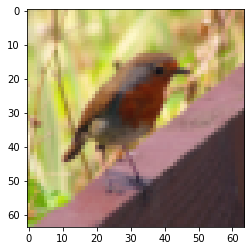

In [3]:
plt.imshow(train_x[10])
print("Y = " + str(train_y[10,0]) + ". It's a " + str(classes[train_y[10,0]]) + " picture.")

In [4]:
train_x = np.asarray(train_x)
train_x = train_x.reshape(train_x.shape[0],-1).T
test_x = np.asarray(test_x)
test_x = test_x.reshape(test_x.shape[0],-1).T
train_x = train_x / 255.0
test_x = test_x / 255.0
print("Train_x : " + str(train_x.shape))
print("Test_x : " + str(test_x.shape))

Train_x : (12288, 209)
Test_x : (12288, 50)


In [5]:
print("Number of training examples = " + str(train_x.shape[0]))
print("Number of testing examples = " + str(test_x.shape[0]))
print("Each image is of size: " + str(train_x[0].shape))
print("train_x : "+ str(train_x.shape))
print("train_y : "+ str(train_y.shape))
print("test_x : "+ str(test_x.shape))
print("test_y : "+ str(test_y.shape))

Number of training examples = 12288
Number of testing examples = 12288
Each image is of size: (209,)
train_x : (12288, 209)
train_y : (209, 1)
test_x : (12288, 50)
test_y : (50, 1)


In [6]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    w1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    parameters = {"W1" : w1,
                  "b1" : b1,
                  "W2" : w2,
                  "b2" : b2}
    return parameters

In [7]:
def linear_forward(a,w,b):
    z = np.dot(w,a) + b
    cache = (a,w,b)
    return z, cache

In [8]:
def linear_activation_forward(a_prev, w, b, activation):
    if activation == "sigmoid":
        z, linear_cache = linear_forward(a_prev,w,b)
        a, activation_cache = sigmoid(z)
    elif activation == "relu":
        z, linear_cache = linear_forward(a_prev,w,b)
        a, activation_cache = relu(z)
    cache = (linear_cache, activation_cache)
    return a, cache

In [9]:
def compute_cost(al ,y):
    m = y.shape[1]
    e= 0.00000001
    cost = (-1/m) * np.sum(np.multiply(y,np.log(al+e)) + np.multiply(1-y, np.log(1-al+e)))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [10]:
def linear_backward(dz, cache):
    a_prev, w, b = cache
    m = a_prev.shape[1]
    dw = np.dot(dz,cache[0].T)/m
    db = np.sum(dz,axis = 1, keepdims=True)/m
    da_prev = np.dot(cache[1].T,dz)
    assert (da_prev.shape == a_prev.shape)
    assert (dw.shape == w.shape)
    assert (db.shape == b.shape)
    
    return da_prev, dw, db

In [11]:
def linear_activation_backward(da, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dz = relu_backward(da, activation_cache)
    elif activation == "sigmoid":
        dz = sigmoid_backward(da, activation_cache)
    da_prev, dw, db = linear_backward(dz, linear_cache)
    return da_prev, dw, db

In [12]:
def update_parameters(parameters,grads , learning_rate):
    L = len(parameters) //2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db"+str(l+1)]
    return parameters

In [13]:
n_x = 12288
n_y = 1
n_h =7
layers_dims = (n_x,n_h,n_y)

In [14]:
def two_layer_model(x,y,layers_dims, learning_rate =0.0075, num_iterations=3000, print_cost = False):
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = x.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x,n_h,n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    y=y.T
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(x, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        ### END CODE HERE ###
        e=0.0000000001
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(y, A2+e) - np.divide(1 - y, 1 - A2+e))
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 =  linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 =  linear_activation_backward(dA1, cache1, activation='relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693049715661845
Cost after iteration 100: 0.642967375796453
Cost after iteration 200: 0.6139330394673875
Cost after iteration 300: 0.560390905427056
Cost after iteration 400: 0.5030563348021752
Cost after iteration 500: 0.4698443714369657
Cost after iteration 600: 0.43556212676261835
Cost after iteration 700: 0.40986976212703585
Cost after iteration 800: 0.3703324418916695
Cost after iteration 900: 0.2801254838927106
Cost after iteration 1000: 0.29654876974620886
Cost after iteration 1100: 0.19625386713853374
Cost after iteration 1200: 0.3552932999022206
Cost after iteration 1300: 0.15117071885027678
Cost after iteration 1400: 0.12822052422986
Cost after iteration 1500: 0.10367328372489662
Cost after iteration 1600: 0.09337080885287112
Cost after iteration 1700: 0.08626917557607018
Cost after iteration 1800: 0.06430868495129866
Cost after iteration 1900: 0.05547814129420366
Cost after iteration 2000: 0.04719097397260219
Cost after iteration 2100: 0.04078880618

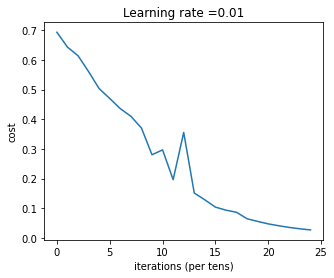

In [15]:
parameters = two_layer_model(train_x, train_y, layers_dims = layers_dims,learning_rate = 0.01, num_iterations = 2500, print_cost =True)


In [16]:
predict_train = predict(train_x, train_y, parameters)


Accuracy: 1.0


In [29]:
test_y = test_y.T
predict_test = predict(test_x, test_y, parameters)
print(predict_test.shape,test_y.shape)

Accuracy: 26.92
(1, 50) (1, 50)


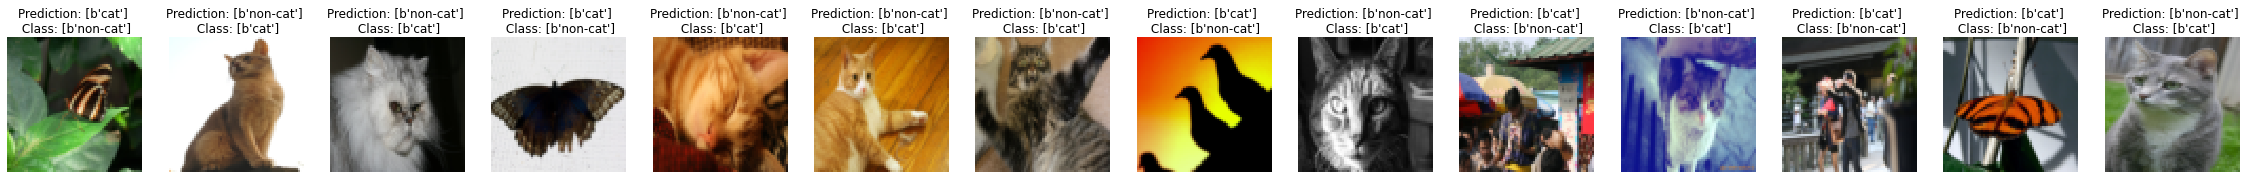

In [32]:
print_mislabeled_images(classes, test_x, test_y, predict_test)